In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from htc.cpp import map_label_image
from htc.evaluation.model_comparison.paper_runs import collect_comparison_runs
from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config
from htc.utils.helper_functions import median_table
from htc.utils.sqldf import sqldf

pio.kaleido.scope.mathjax = None
from htc.tivita.hsi import tivita_wavelengths
from htc.utils.helper_functions import group_median_spectra
from htc.utils.visualization import add_std_fill

[WARNING][htc] The environment variable PATH_Tivita_multiorgan_human was set to /mnt/nvme_4tb/test2    Datasets.py:112
and the path exists, but the data folder data does not exist. Did you set a wrong data_folder_name?                     

[WARNING][htc] The environment variable PATH_Tivita_sepsis_study was set to /mnt/nvme_4tb/test and the Datasets.py:112
path exists, but the data folder data does not exist. Did you set a wrong data_folder_name?                             

In [2]:
font_size = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.serif"] = ["Arial"]
plt.rcParams["font.cursive"] = ["Arial"]
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.it"] = "Arial"
plt.rcParams["mathtext.bf"] = "Arial"
plt.rcParams["font.size"] = font_size
plt.rcParams["xtick.labelsize"] = font_size - 2
plt.rcParams["ytick.labelsize"] = font_size - 2

In [3]:
chirurg_paper_dir = settings_seg.results_dir / "paper_chirurg"
chirurg_paper_dir.mkdir(exist_ok=True, parents=True)

In [4]:
df_runs = collect_comparison_runs(settings_seg.model_comparison_timestamp)
best_run_hsi_img = df_runs.query('model == "image"')["run_hsi"].item()
run_dir = settings.training_dir / "image" / best_run_hsi_img

In [5]:
rows = []
df_test = pd.read_pickle(run_dir / "test_table.pkl.xz")
df_test["subject_name"], df_test["timestamp"] = zip(*df_test["image_name"].map(lambda x: x.split("#")))
for j, row_test in df_test.iterrows():
    rows.append([row_test["image_name"], row_test["dice_metric_image"]])

df = pd.DataFrame(rows, columns=["image_name", "dice"])

In [6]:
df_med = median_table(image_names=df.image_name.unique(), label_mapping=settings_seg.label_mapping)
df1 = df_med[["image_name", "label_index_mapped"]]

In [7]:
df_n_labels = sqldf("""
    SELECT df1.image_name, n_labels, dice
    FROM (
        SELECT image_name, COUNT(DISTINCT label_index_mapped) AS n_labels
        FROM df1
        GROUP BY image_name
    ) AS df1 INNER JOIN df ON df1.image_name = df.image_name
    WHERE n_labels == 7
    ORDER BY dice DESC
""")

In [8]:
sample_image_name = "P062#2020_05_15_18_38_53"

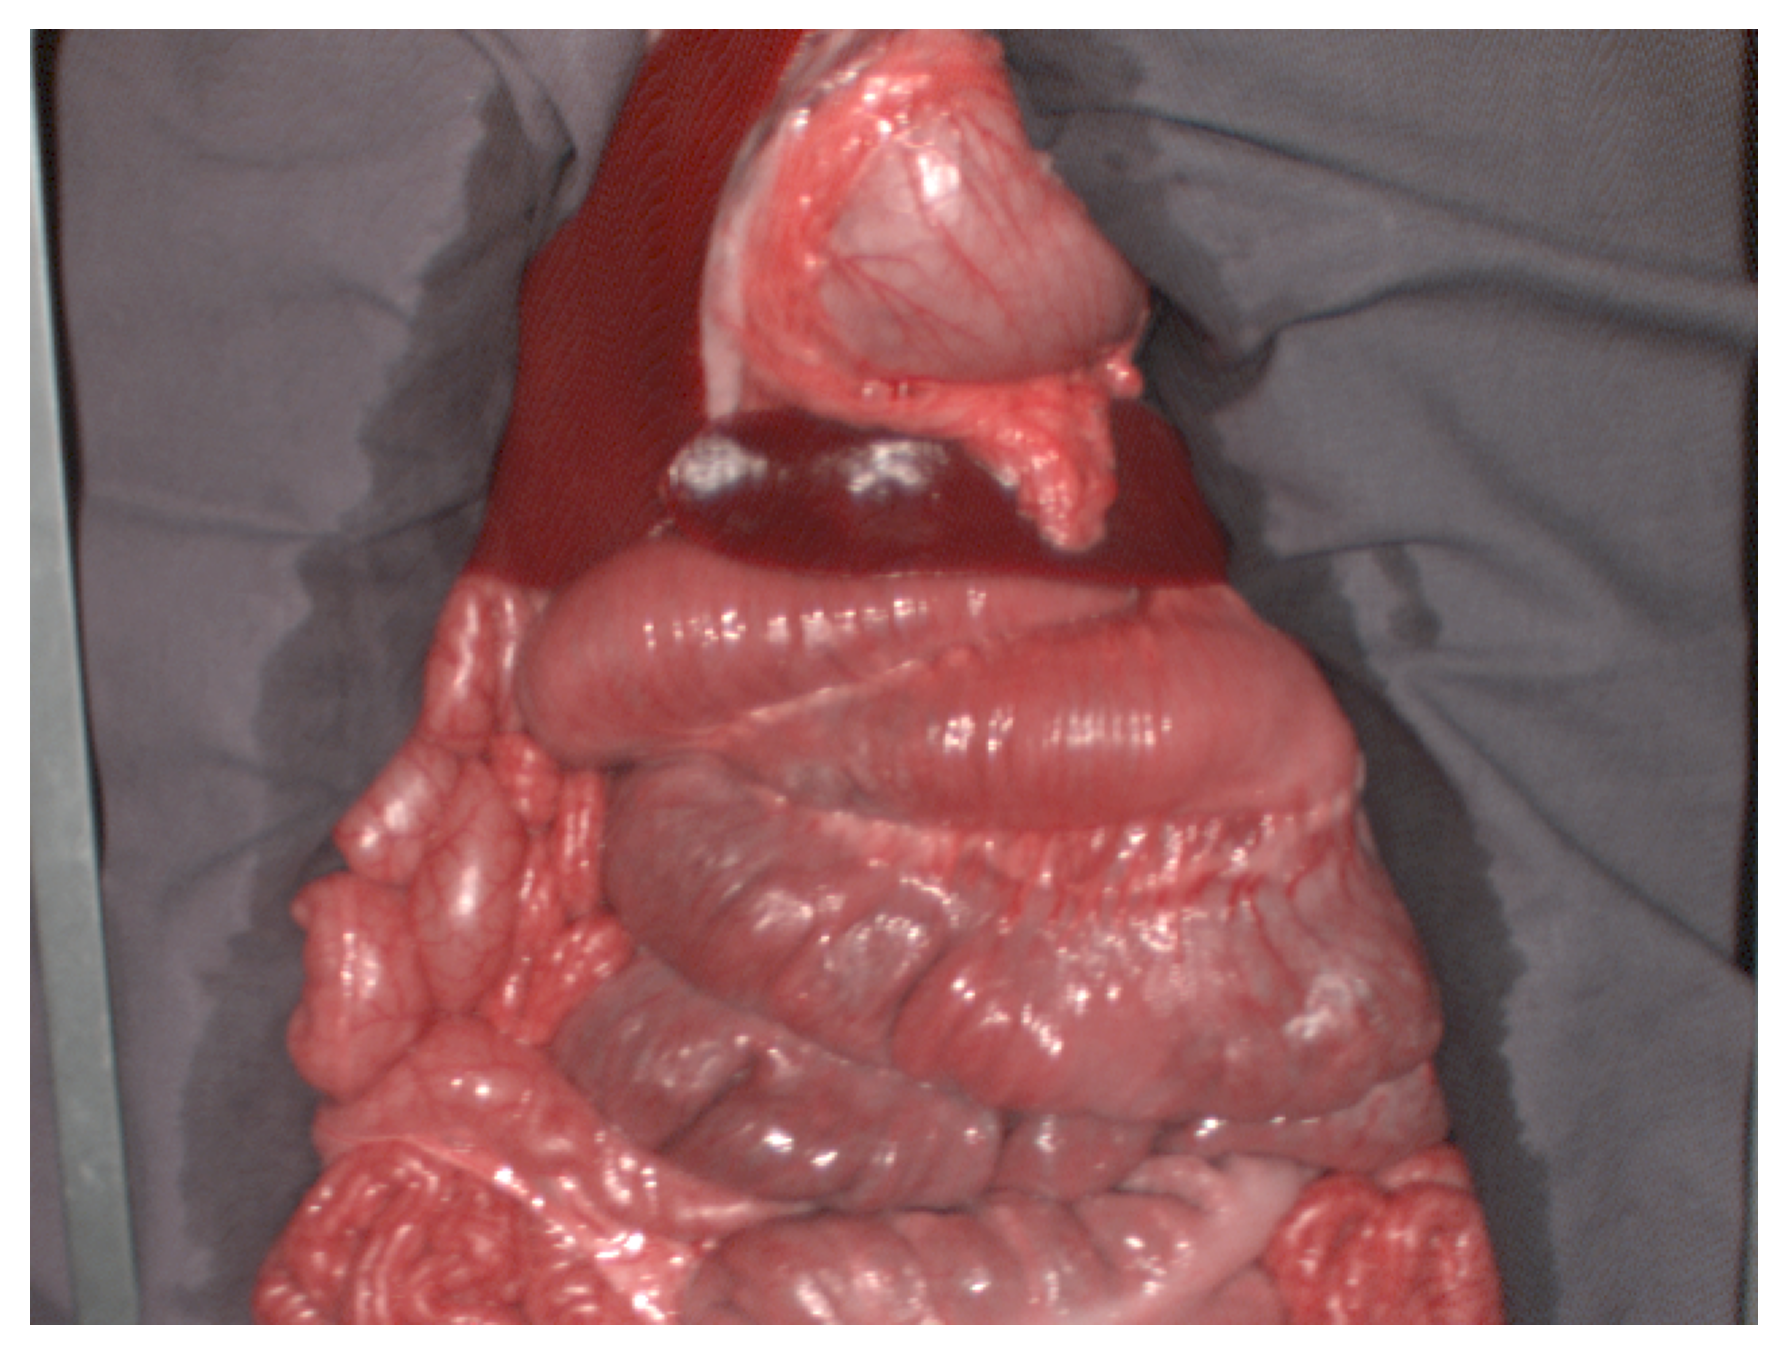

In [9]:
plt.figure(dpi=300, tight_layout=True)
path = DataPath.from_image_name(sample_image_name)
config = Config({"input/n_channels": 3, "input/preprocessing": None})
dataset = DatasetImage([path], train=False, config=config)
rgb = dataset[0]["features"].numpy()
rgb = (rgb * 255).astype(np.uint8)
plt.imshow(rgb)
plt.axis("off")

plt.savefig(chirurg_paper_dir / "sample_rgb.pdf")

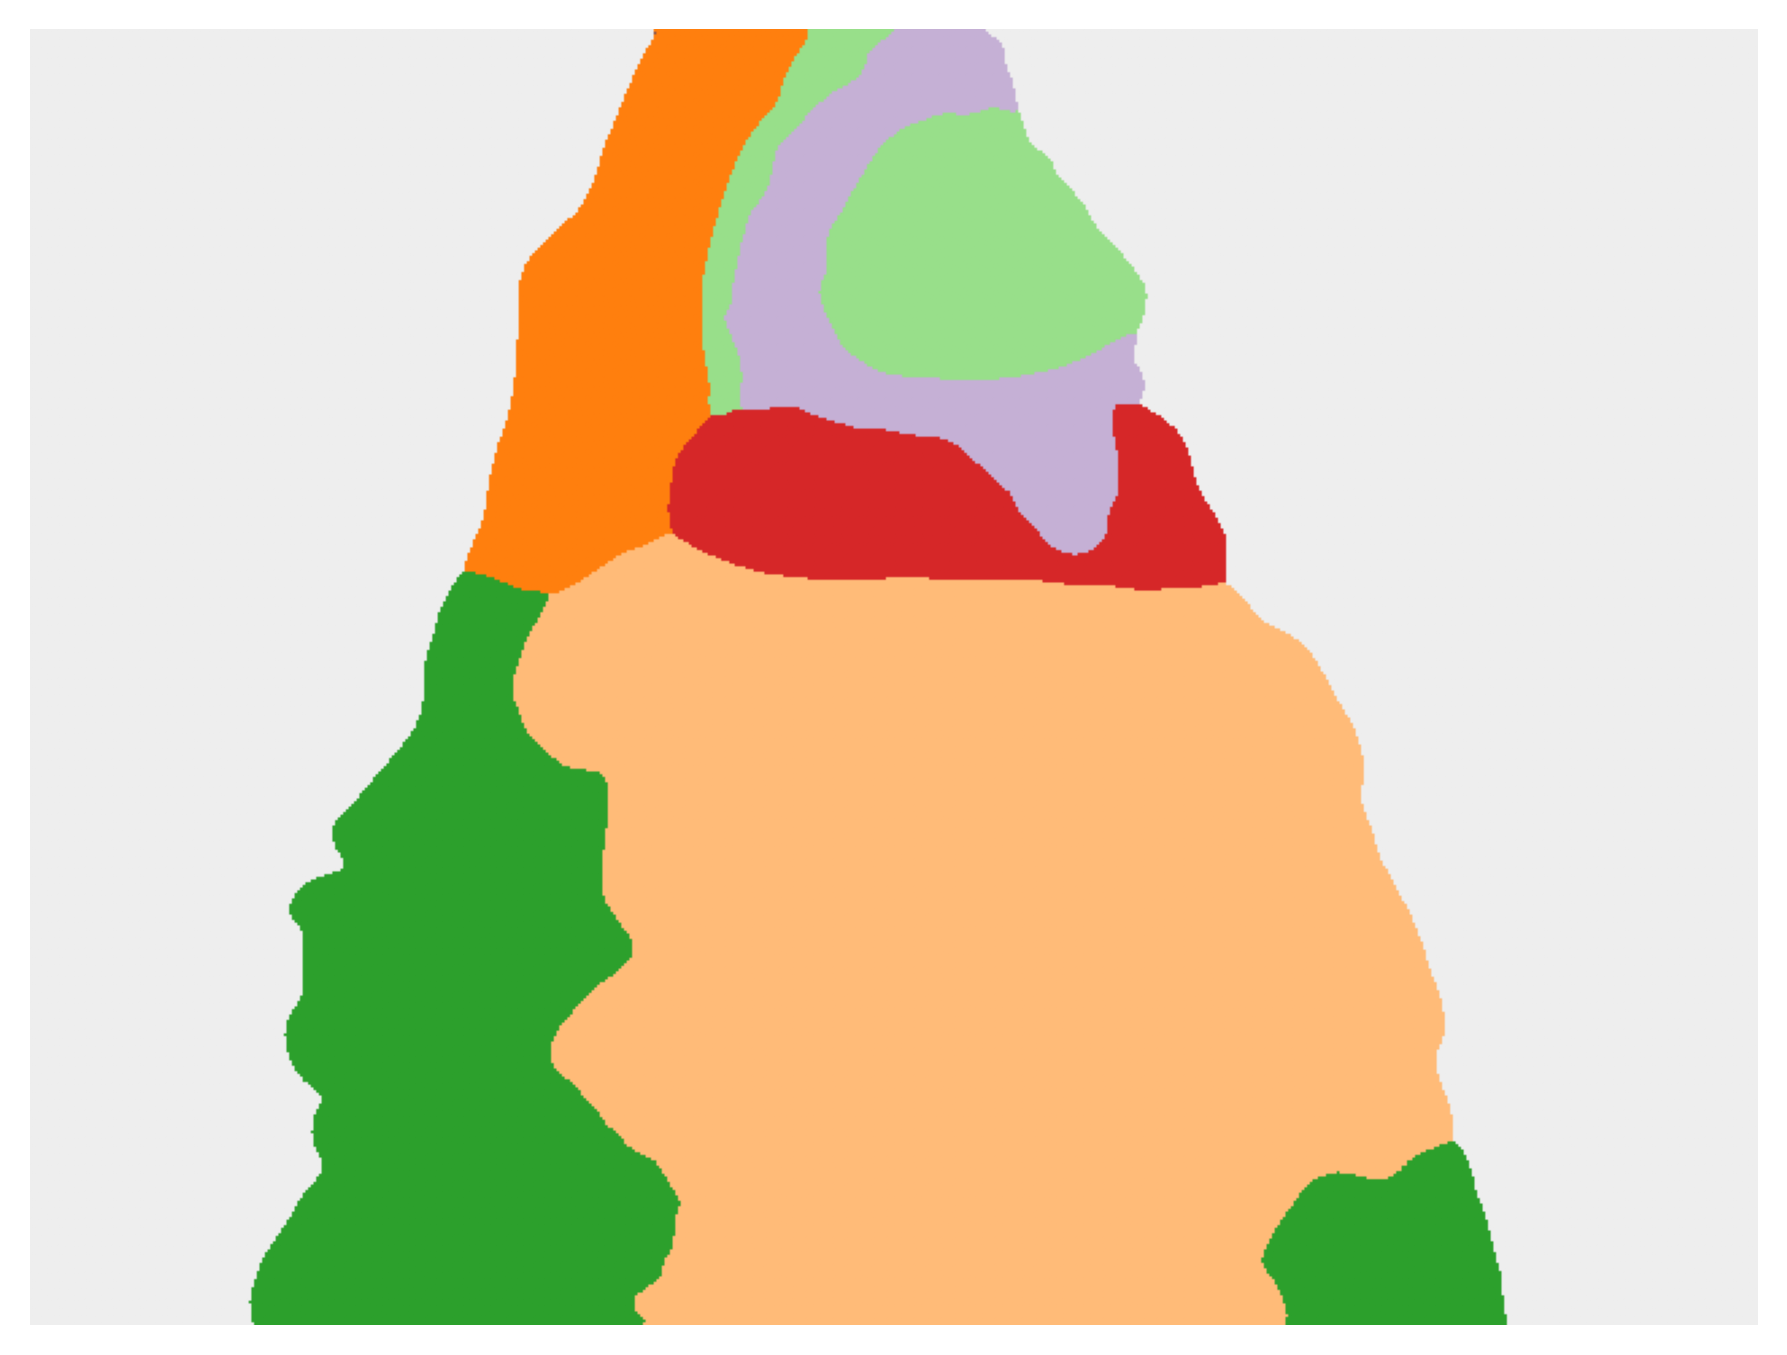

In [10]:
plt.figure(dpi=300, tight_layout=True)
label_mapping = settings_seg.label_mapping
label_mapping.label_colors = settings_seg.label_colors_paper

# Plot predictions
seg = np.load(run_dir / "predictions" / f"{sample_image_name}.npy")
seg = np.argmax(seg, axis=0)
seg_image = map_label_image(seg, label_mapping)
plt.imshow(seg_image)
plt.axis("off")

plt.savefig(chirurg_paper_dir / "sample_seg.pdf")

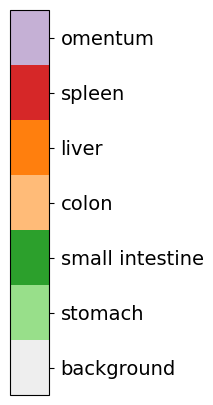

In [11]:
# Colorbar based on the label names/colors
sample_labels = df_med.query("image_name == @sample_image_name").label_name_mapped.unique()
sample_labels_sorted = [l for l in settings_seg.label_colors_paper.keys() if l in sample_labels]
sample_colors = [settings_seg.label_colors_paper[l] for l in sample_labels_sorted]
cmap = mpl.colors.ListedColormap(list(sample_colors))
bounds = list(range(len(sample_labels_sorted)))
bounds.append(max(bounds) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(0.5, 5), dpi=100)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)

tick_names = [settings_seg.labels_paper_renaming.get(l, l) for l in sample_labels_sorted]
tick_names = [l.replace("<br>", "\n") for l in tick_names]

# We want the ticks to be placed in the middle of the box
r = cbar.vmax - cbar.vmin
cbar.set_ticks([cbar.vmin + r / len(tick_names) * (0.5 + i) for i in range(len(tick_names))])
cbar.ax.set_yticklabels(tick_names)
cbar.ax.tick_params(pad=5)

fig.savefig(chirurg_paper_dir / "cbar.pdf", bbox_inches="tight")

In [12]:
df_med_sample = df_med.query("image_name == @sample_image_name")
df_med = df_med.query("label_name in @sample_labels_sorted")
df_med = group_median_spectra(df_med)

In [13]:
# plot grid of spectra
n_rows = 2
n_cols = 3
titles = ["Omentum", "Milz", "Leber", "Colon", "Dünndarm", "Magen"]
label_list = list(reversed(sample_labels_sorted))[:6]
label_paper_names = [settings_seg.labels_paper_renaming.get(l, l) for l in label_list]
fig = make_subplots(
    rows=n_rows, cols=n_cols, shared_xaxes="all", shared_yaxes="all", subplot_titles=titles, vertical_spacing=0.07
)

for l, (label, label_paper_name) in enumerate(zip(label_list, label_paper_names)):
    row = l // n_cols
    col = l % n_cols
    med_spec_sample = df_med_sample.query("label_name_mapped == @label")["median_normalized_spectrum"].item()
    specs_l = np.stack(df_med.query("label_name == @label").median_normalized_spectrum.values)
    mean_spec_l = np.mean(specs_l, axis=0)
    std_spec_l = np.std(specs_l, axis=0)
    label_name = settings_seg.labels_paper_renaming.get(label, label)
    fig = add_std_fill(
        fig,
        mean_spec_l,
        std_spec_l,
        x=tivita_wavelengths(),
        linecolor=settings_seg.label_colors_paper[label],
        label=label_paper_name,
        showlegend=False,
        row=row + 1,
        col=col + 1,
    )
    fig.add_trace(
        go.Scatter(
            x=tivita_wavelengths(), y=med_spec_sample, line=dict(color="black", width=1, dash="dash"), showlegend=False
        ),
        row=row + 1,
        col=col + 1,
    )

    if row == n_rows - 1:
        fig.update_xaxes(title_text="<b>Wellenlänge</b> [nm]", row=row + 1, col=col + 1)
    if col == 0:
        fig.update_yaxes(title_text="<b>Reflektanz</b> [a.u.]", row=row + 1, col=col + 1)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=20))
fig.update_xaxes(tick0=500, dtick=125)
fig.update_layout(height=500, width=900)
fig.update_layout(template="plotly_white", font_family="Arial", font_size=12)

fig.write_image(chirurg_paper_dir / "mean_spectra.pdf")